## Mnist数据集RNN网络

<img src="./img/11.png">

导入Mnist数据集

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib import rnn
from tensorflow.examples.tutorials.mnist import input_data

sess = tf.Session()
mnist = input_data.read_data_sets('data', one_hot=True)
print (mnist.train.images.shape)

Extracting data\train-images-idx3-ubyte.gz
Extracting data\train-labels-idx1-ubyte.gz
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz
(55000, 784)


设置参数

In [2]:
lr = 1e-3
input_size = 28      # 每行输入28个特征点
timestep_size = 28   # 持续输入28行
hidden_size = 256    # 隐含层的数量
layer_num = 2        # LSTM layer 的层数
class_num = 10       # 10分类问题

_X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, class_num])

batch_size = tf.placeholder(tf.int32, [])  
keep_prob = tf.placeholder(tf.float32, [])

定义网络结构

<img src="./img/10.png" style="width:600px;height:300px">

In [3]:
X = tf.reshape(_X, [-1, 28, 28])

def lstm_cell():
    cell = rnn.LSTMCell(hidden_size, reuse=tf.get_variable_scope().reuse)
    return rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)

mlstm_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(layer_num)], state_is_tuple = True)

#用全零来初始化状态
init_state = mlstm_cell.zero_state(batch_size, dtype=tf.float32)

#得到每一层的输出结果
outputs = list()
state = init_state
with tf.variable_scope('RNN'):
    for timestep in range(timestep_size):
        if timestep > 0:
            tf.get_variable_scope().reuse_variables()
        (cell_output, state) = mlstm_cell(X[:, timestep, :],state)
        outputs.append(cell_output)
h_state = outputs[-1]

迭代训练

In [4]:
#Softmax层参数
W = tf.Variable(tf.truncated_normal([hidden_size, class_num], stddev=0.1), dtype=tf.float32)
bias = tf.Variable(tf.constant(0.1,shape=[class_num]), dtype=tf.float32)
y_pre = tf.nn.softmax(tf.matmul(h_state, W) + bias)


# 损失和评估函数
cross_entropy = -tf.reduce_mean(y * tf.log(y_pre))
train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


sess.run(tf.global_variables_initializer())
for i in range(2000):
    _batch_size = 128
    batch = mnist.train.next_batch(_batch_size)
    if (i+1)%200 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={
            _X:batch[0], y: batch[1], keep_prob: 1.0, batch_size: _batch_size})
        # 已经迭代完成的 epoch 数: mnist.train.epochs_completed
        print ("Iter%d, step %d, training accuracy %g" % ( mnist.train.epochs_completed, (i+1), train_accuracy))
    sess.run(train_op, feed_dict={_X: batch[0], y: batch[1], keep_prob: 0.5, batch_size: _batch_size})

# 计算测试数据的准确率
print ("test accuracy %g"% sess.run(accuracy, feed_dict={
    _X: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0, batch_size:mnist.test.images.shape[0]}))

Iter0, step 200, training accuracy 0.929688
Iter0, step 400, training accuracy 0.96875
Iter1, step 600, training accuracy 0.953125
Iter1, step 800, training accuracy 0.976562
Iter2, step 1000, training accuracy 0.96875
Iter2, step 1200, training accuracy 0.984375
Iter3, step 1400, training accuracy 0.976562
Iter3, step 1600, training accuracy 0.984375
Iter4, step 1800, training accuracy 0.992188
Iter4, step 2000, training accuracy 0.976562
test accuracy 0.9839


单个图像RNN每层结果

In [5]:
_batch_size = 5
X_batch, y_batch = mnist.test.next_batch(_batch_size)
print (X_batch.shape, y_batch.shape)
_outputs, _state = sess.run([outputs, state],feed_dict={
            _X: X_batch, y: y_batch, keep_prob: 1.0, batch_size: _batch_size})
print ('_outputs.shape =', np.asarray(_outputs).shape)

(5, 784) (5, 10)
_outputs.shape = (28, 5, 256)


[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


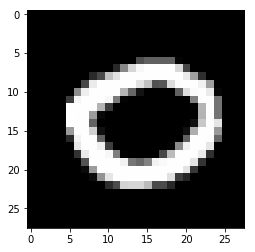

In [6]:
import matplotlib.pyplot as plt
print (mnist.train.labels[4])

X3 = mnist.train.images[4]
img3 = X3.reshape([28, 28])
plt.imshow(img3, cmap='gray')
plt.show()

In [7]:
X3.shape = [-1, 784]
y_batch = mnist.train.labels[0]
y_batch.shape = [-1, class_num]

X3_outputs = np.array(sess.run(outputs, feed_dict={
            _X: X3, y: y_batch, keep_prob: 1.0, batch_size: 1}))
print (X3_outputs.shape)
X3_outputs.shape = [28, hidden_size]
print (X3_outputs.shape)

(28, 1, 256)
(28, 256)


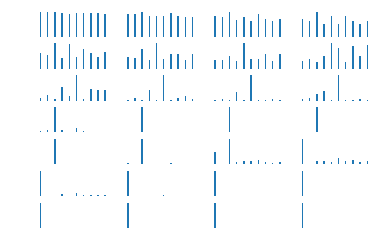

In [8]:

h_W = sess.run(W, feed_dict={
            _X:X3, y: y_batch, keep_prob: 1.0, batch_size: 1})
h_bias = sess.run(bias, feed_dict={
            _X:X3, y: y_batch, keep_prob: 1.0, batch_size: 1})
h_bias.shape = [-1, 10]

bar_index = range(class_num)
for i in range(X3_outputs.shape[0]):
    plt.subplot(7, 4, i+1)
    X3_h_shate = X3_outputs[i, :].reshape([-1, hidden_size])
    pro = sess.run(tf.nn.softmax(tf.matmul(X3_h_shate, h_W) + h_bias))
    plt.bar(bar_index, pro[0], width=0.2 , align='center')
    plt.axis('off')
plt.show()